In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [10]:
dataset_path = "Multi-class Weather Dataset"
image_size = (180, 180)
batch_size = 32
seed = 1337

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
num_classes = len(class_names)

# prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Using 216 files for validation.


In [11]:
# ensure val_ds is batched and preprocessed the same way during training
val_images = []
val_labels = []

for images, labels in val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# one-hot encode labels for ROC curve
num_classes = 4
val_labels_ohe = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

2025-08-04 16:11:31.375698: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# load models
model_mobilenet = tf.keras.models.load_model("BaselineModelWithAugmentation.keras")
model_resnet = tf.keras.models.load_model("ResNet50_Weather.keras")
model_densenet = tf.keras.models.load_model("DenseNet121_Weather.keras")

In [13]:
# Function to compute ROC curve
def compute_roc(model, images, labels_ohe):
    probs = model.predict(images)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_ohe[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [14]:
# compute ROC for each model
fpr_m, tpr_m, auc_m = compute_roc(model_mobilenet, val_images, val_labels_ohe)
fpr_r, tpr_r, auc_r = compute_roc(model_resnet, val_images, val_labels_ohe)
fpr_d, tpr_d, auc_d = compute_roc(model_densenet, val_images, val_labels_ohe)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step


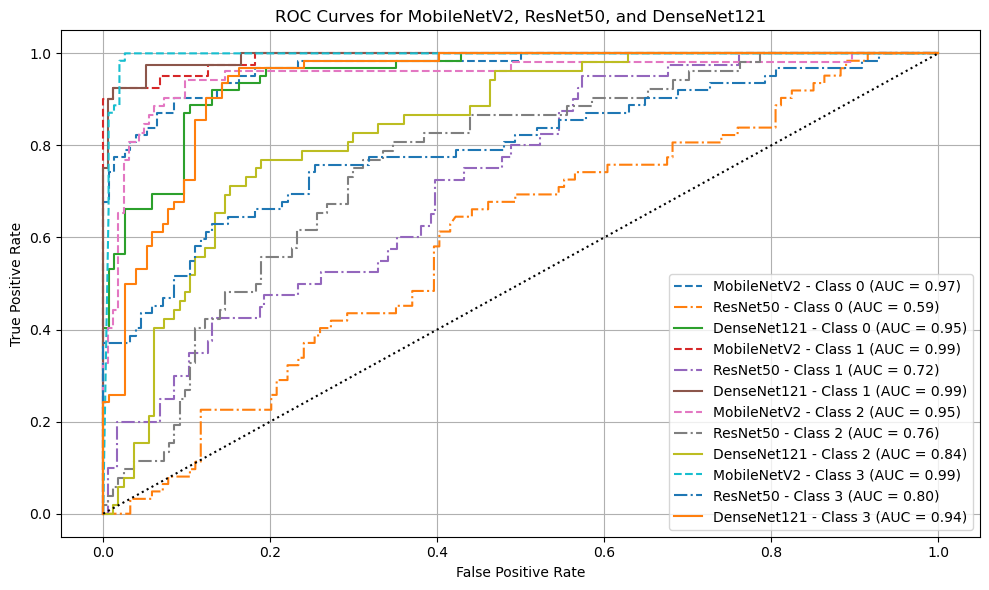

In [15]:
# average ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr_m[i], tpr_m[i], linestyle='--', label=f'MobileNetV2 - Class {i} (AUC = {auc_m[i]:.2f})')
    plt.plot(fpr_r[i], tpr_r[i], linestyle='-.', label=f'ResNet50 - Class {i} (AUC = {auc_r[i]:.2f})')
    plt.plot(fpr_d[i], tpr_d[i], linestyle='-', label=f'DenseNet121 - Class {i} (AUC = {auc_d[i]:.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for MobileNetV2, ResNet50, and DenseNet121')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

MobileNetV2 and DenseNet121 consistently outperform ResNet50 on all classes. ResNet50 struggles, especially for Class 0 (AUC = 0.59), indicating weak prediction capability for that class. MobileNetV2 appears best overall, with near-perfect AUCs for all classes.